<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/RNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
df = pd.read_csv("Energy_Production.csv")
df = df.dropna()
df.head(5)

,DATE,IPG2211A2N
0,1/1/1992,85.5560
1,2/1/1992,80.4178
2,3/1/1992,74.7390
3,4/1/1992,69.8367
4,5/1/1992,67.3781


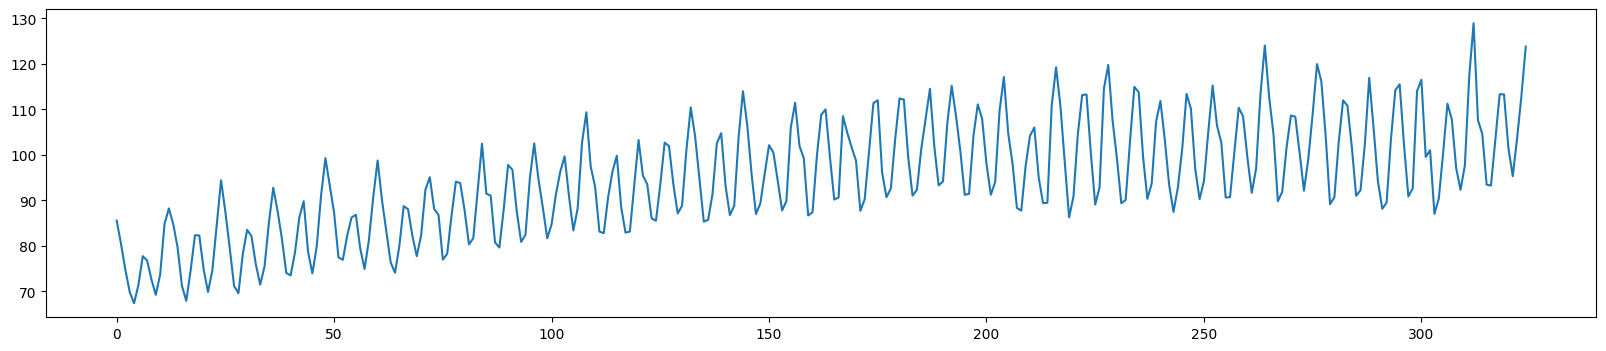

In [7]:
data = df["IPG2211A2N"].values.astype(float)

plt.figure(figsize=(20,4))
plt.plot(data)

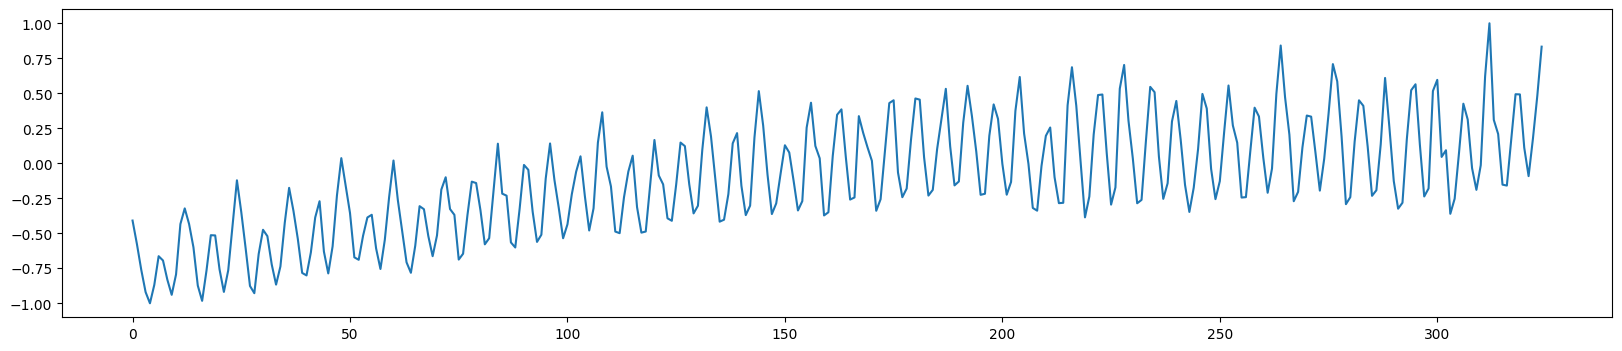

In [10]:
scaler = MinMaxScaler((-1,1))
data_norm = scaler.fit_transform(data.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,4))
plt.plot(data_norm)

In [11]:
len(data)

325

In [16]:
window_size = 25

data_norm_windowed = []
for idx in range(len(data) - (window_size + 1)):
  data_norm_windowed.append((
      torch.tensor(data_norm[idx:idx+window_size], dtype=torch.float32),
      torch.tensor(data_norm[idx+window_size+1], dtype=torch.float32)
  ))

data_norm_windowed[0]

(tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
         -0.8313, -0.9396, -0.7939, -0.4343, -0.3223, -0.4340, -0.5999, -0.8734,
         -0.9827, -0.7669, -0.5138, -0.5153, -0.7577, -0.9188, -0.7643, -0.4445,
         -0.1216]),
 tensor(-0.6068))

In [19]:
class RecurrentNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    self.lstm_1 = nn.LSTM(1, 50)
    self.linear_1 = nn.Linear(50, 1)

    self.hidden = (
        torch.zeros(1,1,50),
        torch.zeros(1,1,50)
    )

  def forward(self, x):

    x, self.hidden = self.lstm_1(x.reshape(len(x), 1, -1), self.hidden)
    x = self.linear_1(x.reshape(len(x), -1))

    return x[-1]

In [52]:
model = RecurrentNetwork()
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [53]:
epochs = 25

model.train()

for epoch in range(epochs):

  for x, y in data_norm_windowed:

    optim.zero_grad()
    model.hidden = (
        torch.zeros(1,1,50),
        torch.zeros(1,1,50)
    )

    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optim.step()

  print(f"Epoch {epoch} Loss {loss}")


Epoch 0 Loss 0.45698946714401245
Epoch 1 Loss 0.43167656660079956
Epoch 2 Loss 0.19674091041088104
Epoch 3 Loss 0.08879461139440536
Epoch 4 Loss 0.08401630073785782
Epoch 5 Loss 0.07670783996582031
Epoch 6 Loss 0.07122721523046494
Epoch 7 Loss 0.0659579336643219
Epoch 8 Loss 0.06147226691246033
Epoch 9 Loss 0.05755074694752693
Epoch 10 Loss 0.05468320474028587
Epoch 11 Loss 0.0526554211974144
Epoch 12 Loss 0.05092513933777809
Epoch 13 Loss 0.04920133575797081
Epoch 14 Loss 0.04745432361960411
Epoch 15 Loss 0.04573845863342285
Epoch 16 Loss 0.04409480839967728
Epoch 17 Loss 0.042545925825834274
Epoch 18 Loss 0.04109879955649376
Epoch 19 Loss 0.03974662348628044
Epoch 20 Loss 0.03847028687596321
Epoch 21 Loss 0.037240587174892426
Epoch 22 Loss 0.036021988838911057
Epoch 23 Loss 0.03478151932358742
Epoch 24 Loss 0.033455073833465576


In [54]:
itm_to_predict = 75

model.eval()

test_data_slice = data_norm[-(window_size*3):-window_size*2].tolist()
for idx in range(itm_to_predict):

  test_data = torch.FloatTensor(test_data_slice[-window_size:])
  with torch.no_grad():
    model.hidden = (
        torch.zeros(1,1,50),
        torch.zeros(1,1,50)
    )

    test_data_slice.append(model(test_data).item())


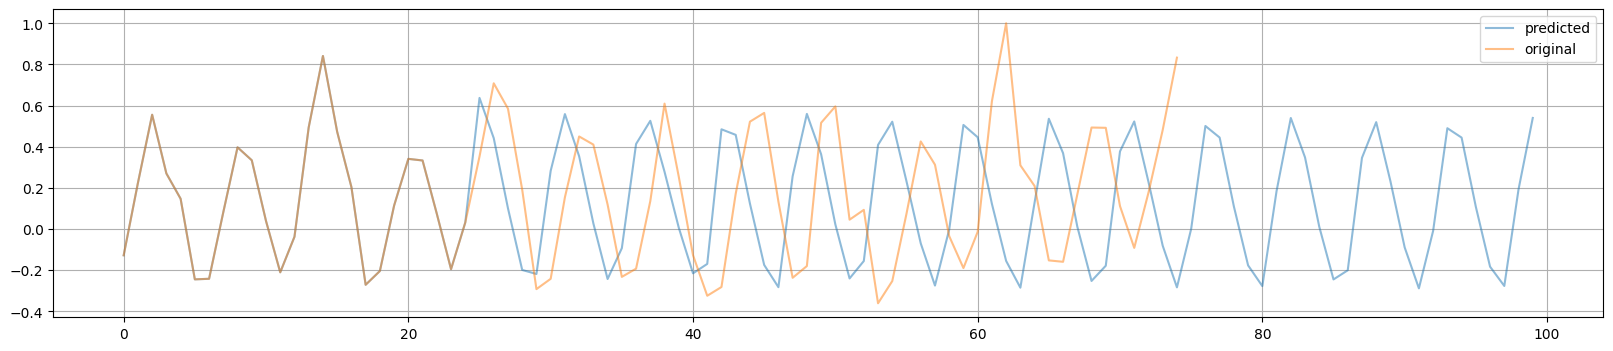

In [55]:
plt.figure(figsize=(20,4))
plt.plot(range(0,len(test_data_slice)), test_data_slice, label="predicted", alpha=.5)
plt.plot(range(0, window_size*3), data_norm[-(window_size*3):], label="original", alpha=.5)
plt.legend()
plt.grid(True)
plt.show()

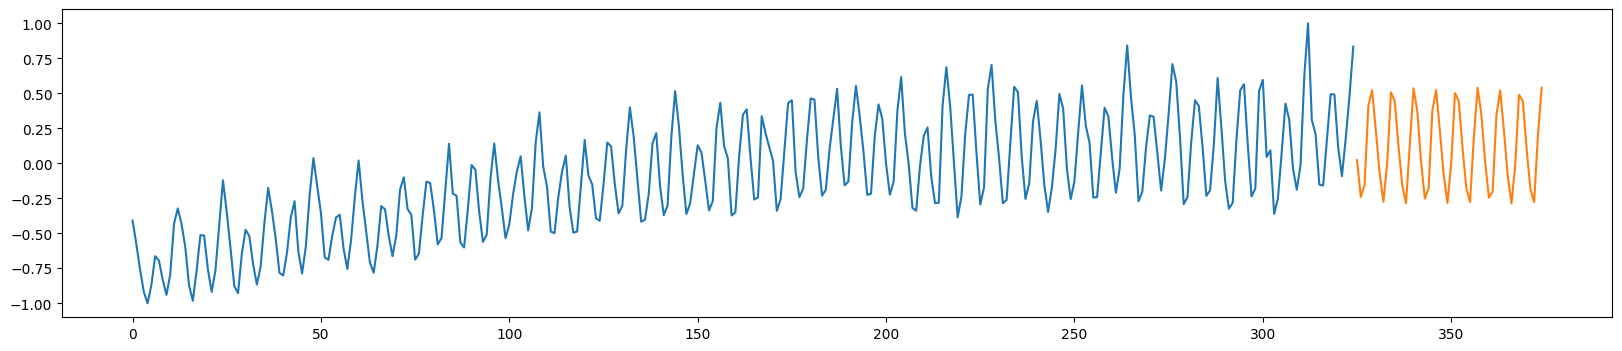

In [56]:
plt.figure(figsize=(20,4))
plt.plot(data_norm)
plt.plot(range(len(data_norm), len(data_norm) + 50), test_data_slice[-50:])